<a href="https://colab.research.google.com/github/Deepu1992/OpenAI-Gym/blob/master/MountainCarQtable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!git clone https://github.com/Deepu1992/OpenAI-Gym.git

## IMPORT LIBRARIES


In [2]:
import numpy as np 
import gym
import pandas as pd
from itertools import combinations_with_replacement
from copy import deepcopy
from matplotlib import pyplot as plt

## DEFINE GLOBAL VARIABLES

In [3]:
ENV                = gym.make('MountainCar-v0') #create environment
N_STEPS            = 5       #chop input space into 'N_STEPS' units in each dimension
EXPLORATION_PROB   = .6      #starting exploration probability. - gets decayed over iterations
RUN_COLAB          = True    #used to avoid rendering  while running on colab

range_obs_space = ENV.observation_space.high - ENV.observation_space.low
obs_step_size   = range_obs_space/N_STEPS
PERFORMANCE     = []  #tracks performance over epochs

## HELPER FUNCTIONS

In [4]:
def encode_obs_state(state):
    return tuple(np.round((state - ENV.observation_space.low)/obs_step_size))

def decode_obs_state(encoded_state):
    return tuple(ENV.observation_space.low + np.array(encoded_state)*obs_step_size)

def play_game(n = 10):    
    for i in range(n):
        s = ENV.reset()
        done = False
        while not done:
            ENV.render()
            action = Q_TABLE.loc[str(encode_obs_state(s))].idxmax()
            s,_,done,_ = ENV.step(action)
        print("Won" if s[0] > .5 else "loss")
        ENV.close()

## CREATE AND INITIALIZE Q TABLE

In [5]:
#create set of all possible input states (in encoded format)
q_indexes = list(combinations_with_replacement((np.linspace(0,N_STEPS,N_STEPS+1)),2))
q_indexes = q_indexes + [i[::-1] for i in q_indexes if i[0] != i[1]]
q_indexes = sorted(q_indexes, key = lambda x: (x[0],x[1]))

#create Q table with random initialized values
Q_TABLE       = pd.DataFrame(data = -.1*np.random.rand(len(q_indexes),3) ,
                       index = [str(i) for i in q_indexes],
                       columns = [0,1,2])

## TRAINING FUNCTION

In [6]:
def train(N = 100000, prob_exploitation = .4, EARLY_STOP = 200):
    
    #initialize    
    count,completed = 0, True

    #initial max_position with lower bound
    max_position = ENV.observation_space.low[0]
    
    #track global best position, experience s_a pairs and winning experiences
    global_max, experience, best_experience = max_position, [], []

    #start training
    for i in range(N):
        
        if i%1000 == 0:
            print(i, "actions completed")
            plt.plot(PERFORMANCE)
            plt.title("Performance over Episode")
            plt.xlabel("Episodes")
            plt.show()

        #on episode completion
        if completed:

            #append best position in experience
            PERFORMANCE.append(max_position) 

            #exit on continously winning 'EARLY_STOP' number of episodes
            if all([i>.5 for i in PERFORMANCE[-EARLY_STOP:]]):
              print("EARLY STOP")
              return

            #print attempt details
            print("Attempt:", count, "Perf:",  np.round(max_position,2), "Global Best:", np.round(global_max,2))
            
            #update episode counter
            count+=1


            #if position better than global best, update best experience
            if max_position > global_max:
                  print("updating global max")
                  global_max = max_position

                  #save winning experiences to memory
                  if max_position > 0.5:
                    best_experience += experience 

            #replay memory
            for s,a in best_experience[::-1]:                   
                    Q_TABLE.loc[s,a] += (global_max)*10 

            #reset
            state = ENV.reset()
            max_position, experience = ENV.observation_space.low[0], []
            
        #show screen
        if not RUN_COLAB:
          ENV.render()
        
        #update state_0
        state_0 = deepcopy(str(encode_obs_state(state)))

        #decay exploration probability
        prob_exploitation += i/2/N

        #choose action
        if np.random.random() < prob_exploitation :        #greedy exploitation
            action = Q_TABLE.loc[str(encode_obs_state(state))].idxmax()

        else:                                              #random exploration
            action = ENV.action_space.sample()
        
        #append state-action pair to episode memory
        experience.append((state_0,action))
        state, reward, completed, _ = ENV.step(action) # perform action and collect state, reward 

        #reward beating episode max 
        if state[0] > max_position:
            reward += 2

            #reward beating global max
            if state[0] > global_max and global_max > 0:
                reward += 5
                print("beat global max")
            
            #update max position
            max_position = state[0]
        
        #update state_1
        state_1 = str(encode_obs_state(state))

        #update Q table
        Q_TABLE.loc[state_0,action] = reward + Q_TABLE.loc[state_1].max()                 

    #close environment  
    ENV.close()

0 actions completed


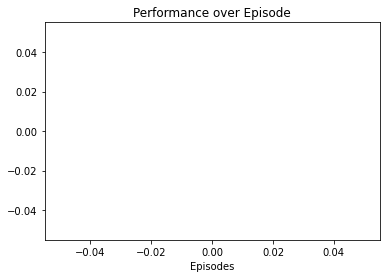

Attempt: 0 Perf: -1.2 Global Best: -1.2
Attempt: 1 Perf: -0.38 Global Best: -1.2
updating global max
Attempt: 2 Perf: -0.42 Global Best: -0.38
Attempt: 3 Perf: -0.44 Global Best: -0.38
Attempt: 4 Perf: -0.29 Global Best: -0.38
updating global max
1000 actions completed


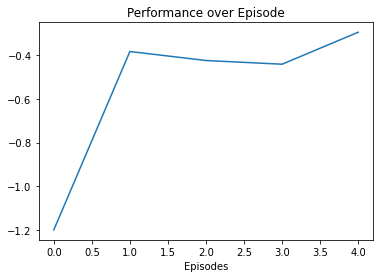

Attempt: 5 Perf: -0.28 Global Best: -0.29
updating global max
Attempt: 6 Perf: -0.43 Global Best: -0.28
Attempt: 7 Perf: -0.39 Global Best: -0.28
Attempt: 8 Perf: -0.41 Global Best: -0.28
Attempt: 9 Perf: -0.42 Global Best: -0.28
2000 actions completed


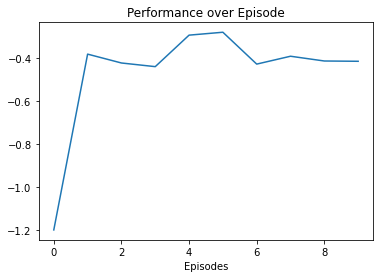

Attempt: 10 Perf: -0.14 Global Best: -0.28
updating global max
Attempt: 11 Perf: -0.02 Global Best: -0.14
updating global max
Attempt: 12 Perf: -0.12 Global Best: -0.02
Attempt: 13 Perf: -0.11 Global Best: -0.02
Attempt: 14 Perf: -0.21 Global Best: -0.02
3000 actions completed


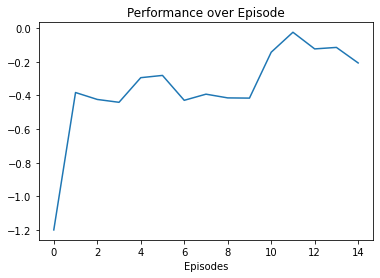

Attempt: 15 Perf: -0.03 Global Best: -0.02
Attempt: 16 Perf: 0.1 Global Best: -0.02
updating global max
beat global max
beat global max
Attempt: 17 Perf: 0.1 Global Best: 0.1
updating global max
Attempt: 18 Perf: -0.05 Global Best: 0.1
Attempt: 19 Perf: 0.07 Global Best: 0.1
4000 actions completed


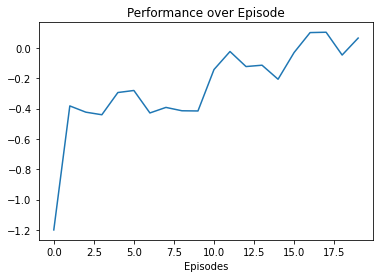

Attempt: 20 Perf: -0.11 Global Best: 0.1
Attempt: 21 Perf: -0.08 Global Best: 0.1
Attempt: 22 Perf: -0.12 Global Best: 0.1
Attempt: 23 Perf: -0.17 Global Best: 0.1
Attempt: 24 Perf: -0.1 Global Best: 0.1
5000 actions completed


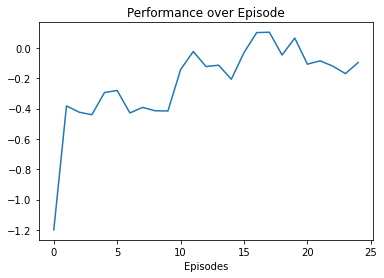

Attempt: 25 Perf: -0.01 Global Best: 0.1
Attempt: 26 Perf: -0.0 Global Best: 0.1
Attempt: 27 Perf: -0.13 Global Best: 0.1
Attempt: 28 Perf: -0.0 Global Best: 0.1
Attempt: 29 Perf: -0.01 Global Best: 0.1
6000 actions completed


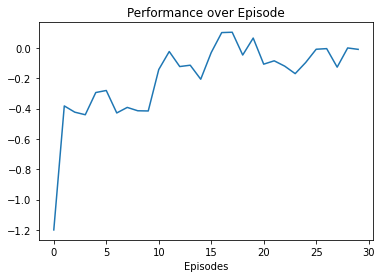

Attempt: 30 Perf: 0.09 Global Best: 0.1
Attempt: 31 Perf: -0.12 Global Best: 0.1
Attempt: 32 Perf: -0.11 Global Best: 0.1
Attempt: 33 Perf: -0.0 Global Best: 0.1
beat global max
beat global max
beat global max
beat global max
beat global max
beat global max
beat global max
beat global max
beat global max
beat global max
beat global max
beat global max
beat global max
beat global max
beat global max
Attempt: 34 Perf: 0.5 Global Best: 0.1
updating global max
beat global max
Attempt: 35 Perf: 0.51 Global Best: 0.5
updating global max
7000 actions completed


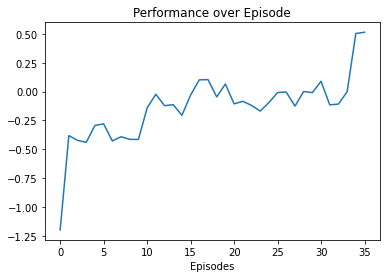

beat global max
Attempt: 36 Perf: 0.53 Global Best: 0.51
updating global max
Attempt: 37 Perf: 0.52 Global Best: 0.53
Attempt: 38 Perf: 0.51 Global Best: 0.53
Attempt: 39 Perf: 0.51 Global Best: 0.53
Attempt: 40 Perf: 0.51 Global Best: 0.53
beat global max
Attempt: 41 Perf: 0.53 Global Best: 0.53
updating global max
Attempt: 42 Perf: 0.5 Global Best: 0.53
8000 actions completed


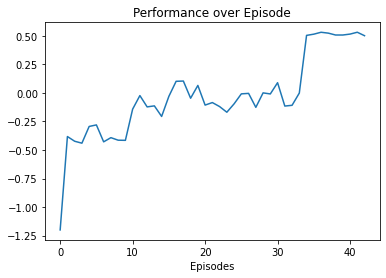

Attempt: 43 Perf: 0.5 Global Best: 0.53
Attempt: 44 Perf: 0.52 Global Best: 0.53
Attempt: 45 Perf: 0.52 Global Best: 0.53
Attempt: 46 Perf: 0.52 Global Best: 0.53
Attempt: 47 Perf: 0.51 Global Best: 0.53
Attempt: 48 Perf: 0.5 Global Best: 0.53
9000 actions completed


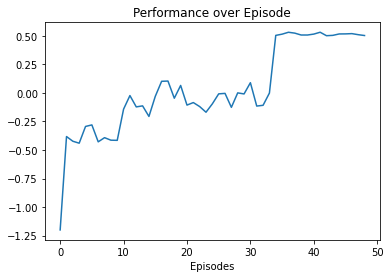

Attempt: 49 Perf: 0.52 Global Best: 0.53
Attempt: 50 Perf: 0.51 Global Best: 0.53
Attempt: 51 Perf: 0.53 Global Best: 0.53
Attempt: 52 Perf: 0.52 Global Best: 0.53
Attempt: 53 Perf: 0.5 Global Best: 0.53
Attempt: 54 Perf: 0.51 Global Best: 0.53
Attempt: 55 Perf: 0.52 Global Best: 0.53
10000 actions completed


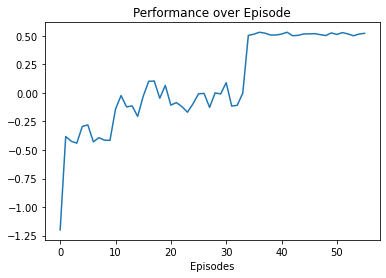

Attempt: 56 Perf: 0.52 Global Best: 0.53
Attempt: 57 Perf: 0.52 Global Best: 0.53
Attempt: 58 Perf: 0.52 Global Best: 0.53
Attempt: 59 Perf: 0.53 Global Best: 0.53
Attempt: 60 Perf: 0.52 Global Best: 0.53
Attempt: 61 Perf: 0.52 Global Best: 0.53
Attempt: 62 Perf: 0.52 Global Best: 0.53
11000 actions completed


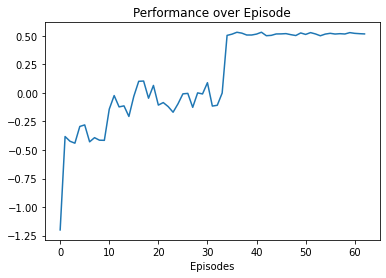

Attempt: 63 Perf: 0.52 Global Best: 0.53
Attempt: 64 Perf: 0.52 Global Best: 0.53
Attempt: 65 Perf: 0.52 Global Best: 0.53
Attempt: 66 Perf: 0.51 Global Best: 0.53
Attempt: 67 Perf: 0.51 Global Best: 0.53
Attempt: 68 Perf: 0.52 Global Best: 0.53
Attempt: 69 Perf: 0.51 Global Best: 0.53
12000 actions completed


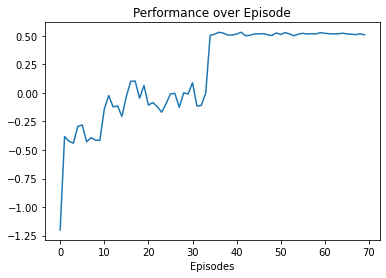

Attempt: 70 Perf: 0.52 Global Best: 0.53
Attempt: 71 Perf: 0.53 Global Best: 0.53
Attempt: 72 Perf: 0.51 Global Best: 0.53
Attempt: 73 Perf: 0.53 Global Best: 0.53
Attempt: 74 Perf: 0.52 Global Best: 0.53
Attempt: 75 Perf: 0.51 Global Best: 0.53
13000 actions completed


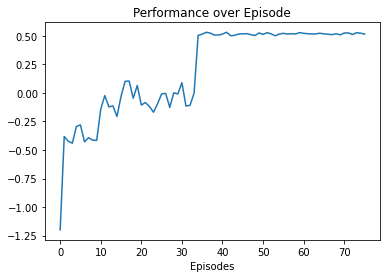

Attempt: 76 Perf: 0.5 Global Best: 0.53
Attempt: 77 Perf: 0.5 Global Best: 0.53
Attempt: 78 Perf: 0.51 Global Best: 0.53
Attempt: 79 Perf: 0.5 Global Best: 0.53
Attempt: 80 Perf: 0.51 Global Best: 0.53
Attempt: 81 Perf: 0.51 Global Best: 0.53
Attempt: 82 Perf: 0.52 Global Best: 0.53
14000 actions completed


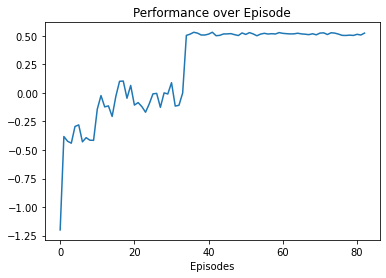

Attempt: 83 Perf: 0.52 Global Best: 0.53
Attempt: 84 Perf: 0.5 Global Best: 0.53
Attempt: 85 Perf: 0.53 Global Best: 0.53
Attempt: 86 Perf: 0.52 Global Best: 0.53
Attempt: 87 Perf: 0.53 Global Best: 0.53
Attempt: 88 Perf: 0.52 Global Best: 0.53
Attempt: 89 Perf: 0.5 Global Best: 0.53
15000 actions completed


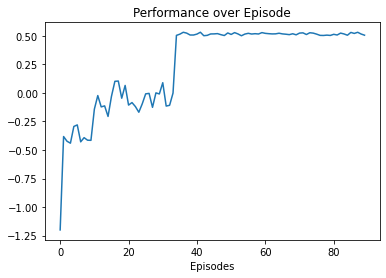

Attempt: 90 Perf: 0.52 Global Best: 0.53
Attempt: 91 Perf: 0.51 Global Best: 0.53
Attempt: 92 Perf: 0.52 Global Best: 0.53
Attempt: 93 Perf: 0.53 Global Best: 0.53
Attempt: 94 Perf: 0.52 Global Best: 0.53
Attempt: 95 Perf: 0.51 Global Best: 0.53
Attempt: 96 Perf: 0.52 Global Best: 0.53
16000 actions completed


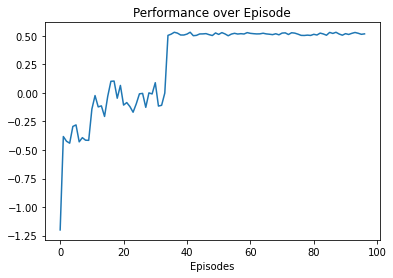

Attempt: 97 Perf: 0.53 Global Best: 0.53
Attempt: 98 Perf: 0.53 Global Best: 0.53
Attempt: 99 Perf: 0.52 Global Best: 0.53
Attempt: 100 Perf: 0.52 Global Best: 0.53
Attempt: 101 Perf: 0.53 Global Best: 0.53
Attempt: 102 Perf: 0.5 Global Best: 0.53
17000 actions completed


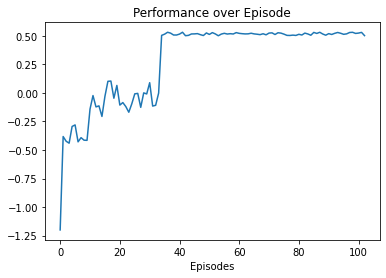

Attempt: 103 Perf: 0.53 Global Best: 0.53
Attempt: 104 Perf: 0.52 Global Best: 0.53
Attempt: 105 Perf: 0.52 Global Best: 0.53
Attempt: 106 Perf: 0.53 Global Best: 0.53
Attempt: 107 Perf: 0.5 Global Best: 0.53
Attempt: 108 Perf: 0.53 Global Best: 0.53
Attempt: 109 Perf: 0.52 Global Best: 0.53
18000 actions completed


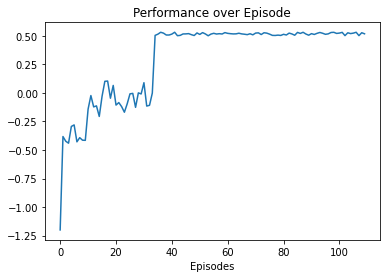

Attempt: 110 Perf: 0.51 Global Best: 0.53
Attempt: 111 Perf: 0.5 Global Best: 0.53
Attempt: 112 Perf: 0.53 Global Best: 0.53
Attempt: 113 Perf: 0.52 Global Best: 0.53
Attempt: 114 Perf: 0.5 Global Best: 0.53
Attempt: 115 Perf: 0.5 Global Best: 0.53
Attempt: 116 Perf: 0.52 Global Best: 0.53
19000 actions completed


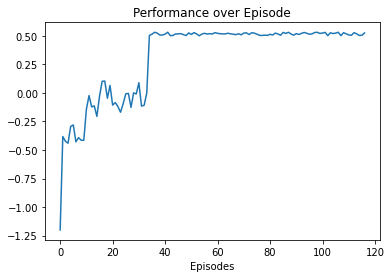

Attempt: 117 Perf: 0.51 Global Best: 0.53
Attempt: 118 Perf: 0.51 Global Best: 0.53
beat global max
Attempt: 119 Perf: 0.53 Global Best: 0.53
updating global max
Attempt: 120 Perf: 0.53 Global Best: 0.53
Attempt: 121 Perf: 0.52 Global Best: 0.53
Attempt: 122 Perf: 0.51 Global Best: 0.53
Attempt: 123 Perf: 0.51 Global Best: 0.53
Attempt: 124 Perf: 0.51 Global Best: 0.53
20000 actions completed


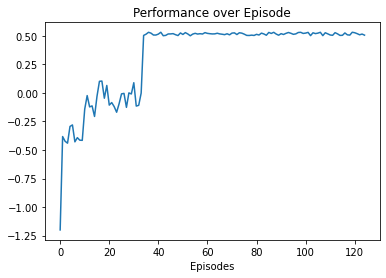

Attempt: 125 Perf: 0.51 Global Best: 0.53
Attempt: 126 Perf: 0.52 Global Best: 0.53
Attempt: 127 Perf: 0.51 Global Best: 0.53
Attempt: 128 Perf: 0.52 Global Best: 0.53
Attempt: 129 Perf: 0.51 Global Best: 0.53
Attempt: 130 Perf: 0.52 Global Best: 0.53
21000 actions completed


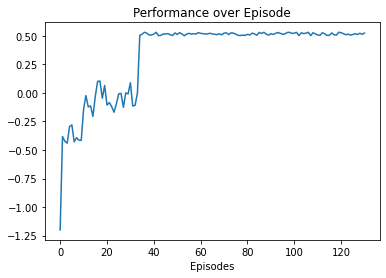

Attempt: 131 Perf: 0.51 Global Best: 0.53
Attempt: 132 Perf: 0.53 Global Best: 0.53
Attempt: 133 Perf: 0.52 Global Best: 0.53
Attempt: 134 Perf: 0.51 Global Best: 0.53
Attempt: 135 Perf: 0.52 Global Best: 0.53
Attempt: 136 Perf: 0.51 Global Best: 0.53
Attempt: 137 Perf: 0.51 Global Best: 0.53
22000 actions completed


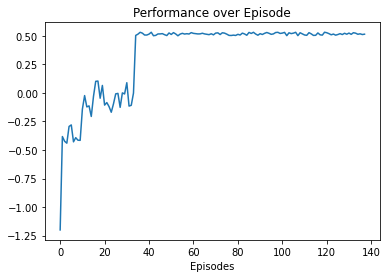

Attempt: 138 Perf: 0.52 Global Best: 0.53
Attempt: 139 Perf: 0.52 Global Best: 0.53
Attempt: 140 Perf: 0.5 Global Best: 0.53
Attempt: 141 Perf: 0.52 Global Best: 0.53
Attempt: 142 Perf: 0.52 Global Best: 0.53
Attempt: 143 Perf: 0.52 Global Best: 0.53
Attempt: 144 Perf: 0.5 Global Best: 0.53
23000 actions completed


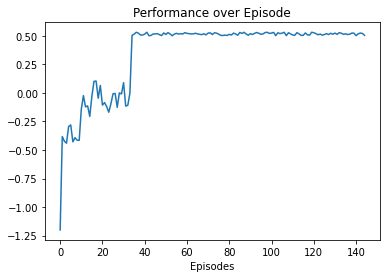

Attempt: 145 Perf: 0.51 Global Best: 0.53
Attempt: 146 Perf: 0.53 Global Best: 0.53
Attempt: 147 Perf: 0.53 Global Best: 0.53
Attempt: 148 Perf: 0.51 Global Best: 0.53
Attempt: 149 Perf: 0.52 Global Best: 0.53
Attempt: 150 Perf: 0.52 Global Best: 0.53
Attempt: 151 Perf: 0.52 Global Best: 0.53
24000 actions completed


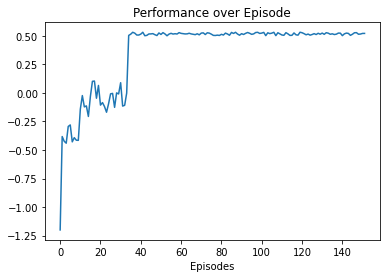

Attempt: 152 Perf: 0.5 Global Best: 0.53
Attempt: 153 Perf: 0.53 Global Best: 0.53
Attempt: 154 Perf: 0.51 Global Best: 0.53
Attempt: 155 Perf: 0.53 Global Best: 0.53
Attempt: 156 Perf: 0.51 Global Best: 0.53
Attempt: 157 Perf: 0.52 Global Best: 0.53
25000 actions completed


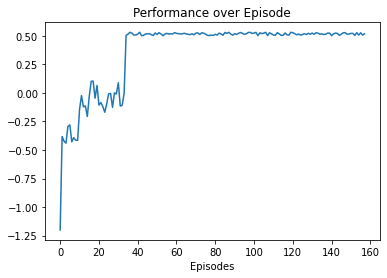

Attempt: 158 Perf: 0.51 Global Best: 0.53
Attempt: 159 Perf: 0.52 Global Best: 0.53
Attempt: 160 Perf: 0.51 Global Best: 0.53
Attempt: 161 Perf: 0.5 Global Best: 0.53
Attempt: 162 Perf: 0.52 Global Best: 0.53
Attempt: 163 Perf: 0.52 Global Best: 0.53
Attempt: 164 Perf: 0.53 Global Best: 0.53
26000 actions completed


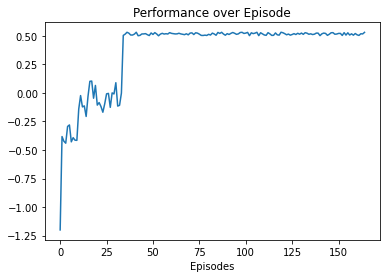

Attempt: 165 Perf: 0.52 Global Best: 0.53
Attempt: 166 Perf: 0.5 Global Best: 0.53
Attempt: 167 Perf: 0.5 Global Best: 0.53
Attempt: 168 Perf: 0.51 Global Best: 0.53
Attempt: 169 Perf: 0.51 Global Best: 0.53
Attempt: 170 Perf: 0.52 Global Best: 0.53
Attempt: 171 Perf: 0.52 Global Best: 0.53
Attempt: 172 Perf: 0.51 Global Best: 0.53
27000 actions completed


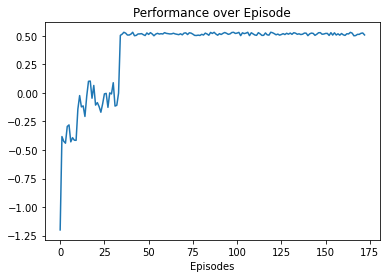

Attempt: 173 Perf: 0.52 Global Best: 0.53
Attempt: 174 Perf: 0.5 Global Best: 0.53
Attempt: 175 Perf: 0.51 Global Best: 0.53
Attempt: 176 Perf: 0.52 Global Best: 0.53
Attempt: 177 Perf: 0.51 Global Best: 0.53
Attempt: 178 Perf: 0.52 Global Best: 0.53
Attempt: 179 Perf: 0.51 Global Best: 0.53
28000 actions completed


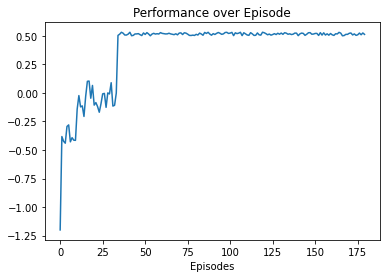

Attempt: 180 Perf: 0.52 Global Best: 0.53
Attempt: 181 Perf: 0.52 Global Best: 0.53
Attempt: 182 Perf: 0.52 Global Best: 0.53
Attempt: 183 Perf: 0.52 Global Best: 0.53
Attempt: 184 Perf: 0.52 Global Best: 0.53
Attempt: 185 Perf: 0.51 Global Best: 0.53
Attempt: 186 Perf: 0.51 Global Best: 0.53
29000 actions completed


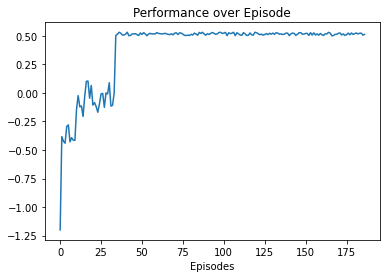

Attempt: 187 Perf: 0.51 Global Best: 0.53
Attempt: 188 Perf: 0.51 Global Best: 0.53
Attempt: 189 Perf: 0.51 Global Best: 0.53
Attempt: 190 Perf: 0.53 Global Best: 0.53
Attempt: 191 Perf: 0.51 Global Best: 0.53
Attempt: 192 Perf: 0.52 Global Best: 0.53
Attempt: 193 Perf: 0.5 Global Best: 0.53
30000 actions completed


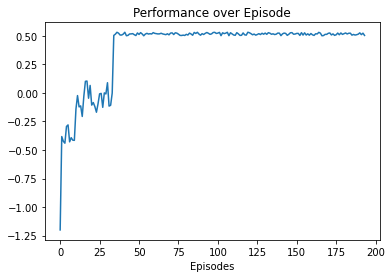

Attempt: 194 Perf: 0.5 Global Best: 0.53
Attempt: 195 Perf: 0.52 Global Best: 0.53
Attempt: 196 Perf: 0.5 Global Best: 0.53
Attempt: 197 Perf: 0.52 Global Best: 0.53
Attempt: 198 Perf: 0.53 Global Best: 0.53
Attempt: 199 Perf: 0.53 Global Best: 0.53
Attempt: 200 Perf: 0.52 Global Best: 0.53
31000 actions completed


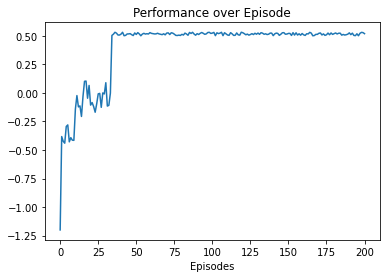

Attempt: 201 Perf: 0.53 Global Best: 0.53
Attempt: 202 Perf: 0.51 Global Best: 0.53
Attempt: 203 Perf: 0.51 Global Best: 0.53
Attempt: 204 Perf: 0.53 Global Best: 0.53
Attempt: 205 Perf: 0.53 Global Best: 0.53
Attempt: 206 Perf: 0.51 Global Best: 0.53
Attempt: 207 Perf: 0.53 Global Best: 0.53
32000 actions completed


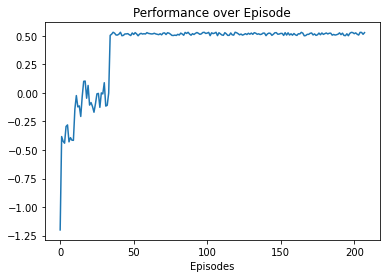

Attempt: 208 Perf: 0.52 Global Best: 0.53
Attempt: 209 Perf: 0.51 Global Best: 0.53
Attempt: 210 Perf: 0.52 Global Best: 0.53
Attempt: 211 Perf: 0.51 Global Best: 0.53
Attempt: 212 Perf: 0.52 Global Best: 0.53
Attempt: 213 Perf: 0.51 Global Best: 0.53
33000 actions completed


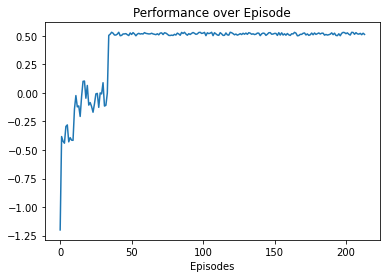

Attempt: 214 Perf: 0.52 Global Best: 0.53
Attempt: 215 Perf: 0.52 Global Best: 0.53
Attempt: 216 Perf: 0.52 Global Best: 0.53
Attempt: 217 Perf: 0.51 Global Best: 0.53
Attempt: 218 Perf: 0.52 Global Best: 0.53
Attempt: 219 Perf: 0.5 Global Best: 0.53
Attempt: 220 Perf: 0.51 Global Best: 0.53
34000 actions completed


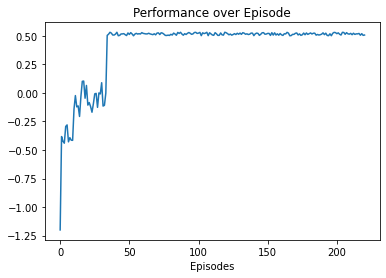

Attempt: 221 Perf: 0.51 Global Best: 0.53
Attempt: 222 Perf: 0.53 Global Best: 0.53
Attempt: 223 Perf: 0.52 Global Best: 0.53
Attempt: 224 Perf: 0.5 Global Best: 0.53
Attempt: 225 Perf: 0.53 Global Best: 0.53
Attempt: 226 Perf: 0.53 Global Best: 0.53
Attempt: 227 Perf: 0.51 Global Best: 0.53
35000 actions completed


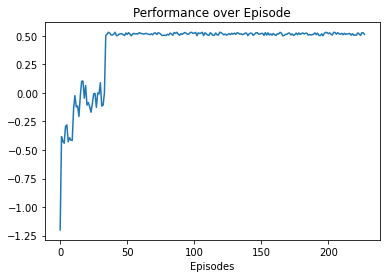

Attempt: 228 Perf: 0.5 Global Best: 0.53
Attempt: 229 Perf: 0.52 Global Best: 0.53
Attempt: 230 Perf: 0.52 Global Best: 0.53
Attempt: 231 Perf: 0.52 Global Best: 0.53
Attempt: 232 Perf: 0.52 Global Best: 0.53


In [7]:
train(N = 100000, prob_exploitation = 1-EXPLORATION_PROB)

## VISUALIZE POLICY

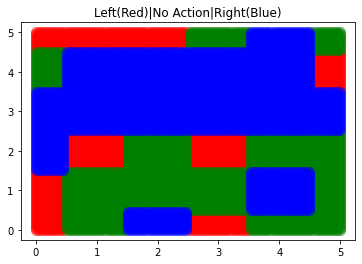

In [12]:
#create set of all possible input states (in encoded format)
q_indexes = list(combinations_with_replacement((np.linspace(0,N_STEPS,100)),2))
q_indexes = q_indexes + [i[::-1] for i in q_indexes if i[0] != i[1]]
q_indexes = sorted(q_indexes, key = lambda x: (x[0],x[1]))

x = [i[0] for i in q_indexes] #position
v = [i[1] for i in q_indexes] #velocity
a = np.array([x,v])           #collect input state in array

#create categories, colour map
categories = [Q_TABLE.loc[str(encode_obs_state(state*obs_step_size + ENV.observation_space.low))].idxmax()\
              for state in q_indexes]

scatter_x = np.array(x)
scatter_y = np.array(v)
group = np.array(categories)
cdict = {0: 'red', 1: 'green', 2: 'blue'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], 
               c = cdict[g], label = g,
               s = 100,
               alpha = .5)
plt.title("Left(Red)|No Action|Right(Blue)")
plt.show()